In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd   
from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from gensim.matutils import cossim
from gensim.models.phrases import Phrases, Phraser
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import pickle
import random
import sys
from tqdm import tqdm
from sklearn import manifold


[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Word2vec Embeddings


In [2]:
lang = 'portuguese'

In [3]:
#cargo bases 
df_train = pd.read_csv(f'data/{lang}_data.csv')

trainset = (df_train.text_norm.str.split(' ')).to_list()

In [4]:
collocations = Phrases(sentences=trainset, min_count=10,threshold=0.5,scoring='npmi') # threshold: minimo score aceptado
to_collocations = Phraser(collocations)
df_collocations =pd.DataFrame([x for x in collocations.export_phrases(trainset)],columns=["bigram","score"])

df_collocations.drop_duplicates().sort_values(by="score",ascending=False).to_csv(f'data/bigramas/bigramas_{lang}.csv', index = False)


In [5]:
df_collocations.drop_duplicates().head(15)

,bigram,score
0,b'rio gallego',0.651516
1,b'hora meia',0.561650
2,b'perito moreno',0.986473
3,b'valer pena',0.897180
4,b'estancia cristino',0.840968
6,b'lago argentino',0.770856
7,b'levar lanche',0.599760
8,b'bloco gelo',0.622509
11,b'rio hielo',0.677232
13,b'parque nacional',0.768243


In [6]:
trainset_ngrams = to_collocations[trainset]

## Embeddings General

In [7]:
# "window" es el tamaño de la ventana. windows = 10, usa 10 palabras a la izquierda y 10 palabras a la derecha
# "n_dim" es la dimension (i.e. el largo) de los vectores de word2vec
# "workers" es el numero de cores que usa en paralelo. Para aprobechar eso es necesario tener instalado Cython)
# "sample": word2vec filtra palabras que aparecen una fraccion mayor que "sample"
# "min_count": Word2vec filtra palabras con menos apariciones que  "min_count"
# "sg": para correr el Skipgram model (sg = 1), para correr el CBOW (sg = 0)
# para mas detalle ver: https://radimrehurek.com/gensim/models/word2vec.html

w2v_model = Word2Vec(trainset_ngrams, workers=4, size= 20, min_count = 10, window = 10, sample = 1e-3,negative=5,sg=1)


In [8]:
w2v_model.save(f"models/model_{lang}.model")

### Distancia entre palabras

In [9]:
palabra_a = 'barco'
palabra_b = 'bom'
print (f"{palabra_a}-{palabra_b} similarity:",w2v_model.wv.n_similarity([palabra_a], [palabra_b]))

barco-bom similarity: 0.5972292


### Palabras mas cercanas

In [10]:
w2v_model.wv.most_similar(positive=["glaciar"], negative=[], topn=25)

[('glacial', 0.9017165899276733),
 ('geleira', 0.8961523771286011),
 ('navegar', 0.8895564079284668),
 ('perito', 0.8862797021865845),
 ('spegazini', 0.8757434487342834),
 ('upsalar_spegazzini', 0.8591139316558838),
 ('navegacao', 0.8550480604171753),
 ('perito_moreno', 0.849107027053833),
 ('canal', 0.8478042483329773),
 ('iceberg', 0.8464165925979614),
 ('uppsala', 0.8427501916885376),
 ('upsalo', 0.8408942818641663),
 ('spegazzini', 0.8408842086791992),
 ('atrave', 0.8401709198951721),
 ('upsalar', 0.8370072841644287),
 ('upsalla', 0.8336359262466431),
 ('face', 0.8335937857627869),
 ('barco', 0.8277672529220581),
 ('navega', 0.8258945941925049),
 ('deslocamento', 0.8154070377349854),
 ('tempano', 0.8140438199043274),
 ('aproximacao', 0.8113919496536255),
 ('onelli', 0.8068482875823975),
 ('upsala_spegazzini', 0.8060671091079712),
 ('upsalo_spegazzini', 0.8048068284988403)]

In [11]:
w2v_model.wv.most_similar(positive=['hotel'], negative=[], topn=25)

[('buscou', 0.9320610165596008),
 ('buscar', 0.9259470701217651),
 ('out', 0.9171119928359985),
 ('saida', 0.9140504598617554),
 ('hostel', 0.9125410914421082),
 ('pousada', 0.8969638347625732),
 ('buscar_hotel', 0.8955209255218506),
 ('pontualmente', 0.891757607460022),
 ('hoteis', 0.8833101987838745),
 ('confirmar', 0.8752905130386353),
 ('embarque', 0.8740520477294922),
 ('apanhar_hotel', 0.8727309107780457),
 ('cedinho', 0.8713687062263489),
 ('horario_combinar', 0.8701239824295044),
 ('apanhar', 0.8682962656021118),
 ('rodoviaria', 0.8602210283279419),
 ('translar', 0.8590571284294128),
 ('terminal', 0.8570679426193237),
 ('busca', 0.8502300977706909),
 ('guiche', 0.8489677906036377),
 ('comprar_ticket', 0.848430871963501),
 ('transfer', 0.8481352925300598),
 ('aeroporto', 0.8475863337516785),
 ('hotei', 0.8475804328918457),
 ('embarcar', 0.8463844060897827)]

### Visualizacion distancia entre grupos de palabras

In [12]:
adjtetivos = ["bom","excelente","otimo",]
adjtetivos_2 = ["carissimo","horrivel","real"]
glaciar = ["glaciar","trekking","perito_moreno",]
ciudad = ["calafate","bar","centrinho","hotel"]

palabras = adjtetivos + adjtetivos_2 + glaciar + ciudad 
colores = ["black"]*len(adjtetivos)+["blue"]*len(adjtetivos_2)+["green"]*len(glaciar)+["red"]*len(ciudad) 

In [13]:
# Armo una matriz de distancias
distancias=np.zeros((len(palabras),len(palabras))) #matriz cuadrada
for i,ti in enumerate(palabras):
    for j,tj in enumerate(palabras):
        distancias[i,j] = abs(1-w2v_model.wv.similarity(ti,tj))

#distancias

In [14]:
# Reduccion de la dimensionalidad y visualizacion 
from sklearn.manifold import MDS
from sklearn.manifold import TSNE 
def visualize_embeddings(distancias,palabras,colores,perplexity):
    plt.figure(figsize=(20,10))
    # Reduccion de la dimensionalidad y visualizacion 
    mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=123,
                       dissimilarity="precomputed", n_jobs=1)
    Y = mds.fit(distancias).embedding_
    plt.subplot(1,2,1)
    plt.scatter(Y[:, 0], Y[:, 1],color="black",s=3)
    for label, x, y, color in zip(palabras, Y[:, 0], Y[:, 1],colores):
        plt.annotate(label, xy=(x, y), xytext=(0, 0),color=color, textcoords='offset points',size=13)
    plt.title("MDS")
    # Reduccion de la dimensionalidad y visualizacion 
    tsne = TSNE(n_components=2,metric="precomputed",learning_rate=1000, random_state=123,perplexity=perplexity)
    np.set_printoptions(suppress=True)
    plt.subplot(1,2,2)
    Y = tsne.fit_transform(distancias)
    plt.scatter(Y[:, 0], Y[:, 1],color="black",s=3)
    for label, x, y, color in zip(palabras, Y[:, 0], Y[:, 1],colores):
        plt.annotate(label, xy=(x, y), xytext=(0, 0),color=color, textcoords='offset points',size=13)
    plt.title("TSNE")

/home/vscode/.local/lib/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


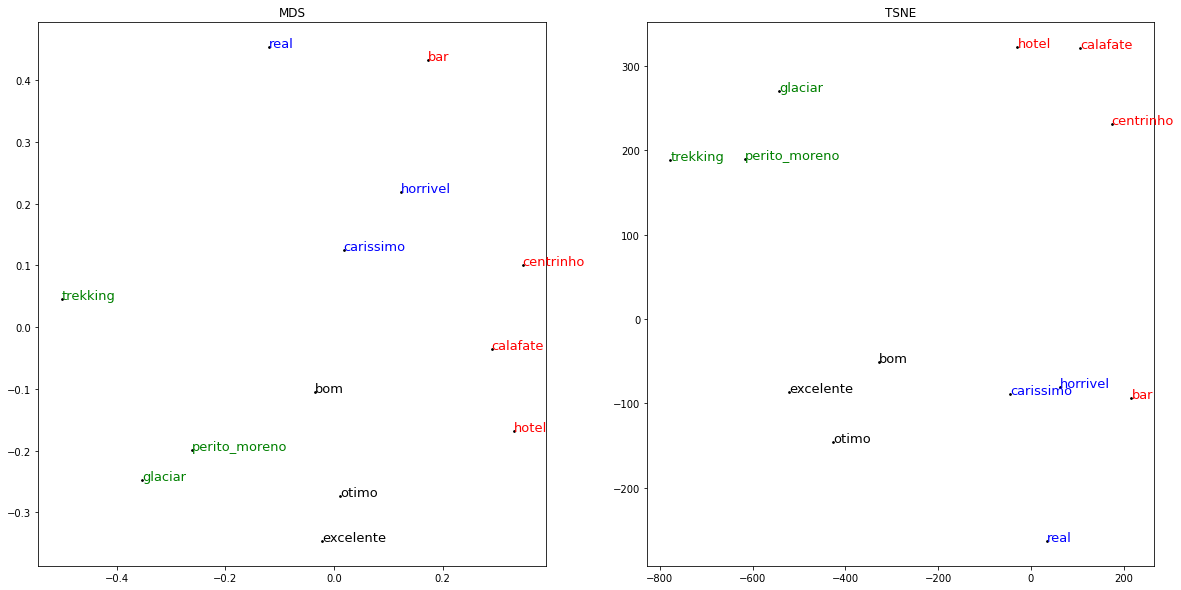

In [15]:
visualize_embeddings(distancias,palabras,colores,perplexity=4)

## Embeddings por categoria

In [16]:
for cat in list(set(df_train.categoria_souldata)):

    trainset = (df_train.loc[df_train.categoria_souldata == cat].text_norm.str.split(' ')).to_list()
    collocations = Phrases(sentences=trainset, min_count=10,threshold=0.5,scoring='npmi') # threshold: minimo score aceptado
    to_collocations = Phraser(collocations)
    df_collocations =pd.DataFrame([x for x in collocations.export_phrases(trainset)],columns=["bigram","score"])

    df_collocations.drop_duplicates().sort_values(by="score",ascending=False).to_csv(f'data/bigramas/bigramas_{lang}_{cat}.csv', index = False)
    
    trainset_ngrams = to_collocations[trainset]
    w2v_model = Word2Vec(trainset_ngrams, workers=4, size= 20, min_count = 10, window = 10, sample = 1e-3,negative=5,sg=1)

    w2v_model.save(f"models/model_{lang}_{cat}.model")